In [2]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28


     |████████████████████████████████| 30.6MB 1.4MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


Printing the matched keypoints for both the images
1 and 2


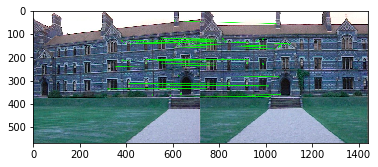

2 and 3


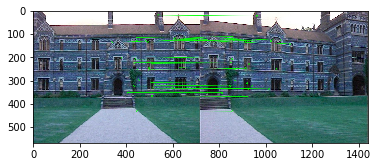

In [36]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import random

MIN_MATCH_COUNT = 10

img1 = cv2.imread('keble_a.jpg',1)         
img2 = cv2.imread('keble_b.jpg',1) 
img3= cv2.imread('keble_c.jpg',1)



# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
kp3, des3 = sift.detectAndCompute(img3,None)


FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)
matches2= flann.knnMatch(des2,des3,k=2)

# store all the good matches as per Lowe's ratio test.
good2=[]
good = []
for m,n in matches:
    if m.distance < 0.2*n.distance:
        good.append(m)
        

for m,n in matches2:
  if m.distance < 0.2*n.distance:
    good2.append(m)
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)

img12=cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
img32=cv2.drawMatches(img2,kp2,img3,kp3,good2,None,**draw_params)


print('Printing the matched keypoints for both the images')
print('1 and 2')
plt.imshow(img12)
plt.show()

print('2 and 3')
plt.imshow(img32)
plt.show()

The homography function takes the list of matching points as an argument 


In [0]:
def calculateHomography(correspondences):
    
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

The following function calculates geometric distance 

In [0]:
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    
    return np.linalg.norm(error)



The following function takes the matching keypoints list and computes the homography based on threshold value provided



In [0]:
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        
        corr3 = corr[random.randrange(0, len(corr))]
        
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1,corr2,corr3, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
                
        dlist=[]
        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            dlist.append(d)
            
        darray = np.asarray(dlist)
        
        max_d, min_d = max(darray),min(darray)
        darray = (darray - min_d )/(max_d-min_d)
      
        
        thresh_d = 0.5
        
        
        inliers = corr[darray<thresh_d,:]

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        print ("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))
        
        if len(maxInliers) > (len(corr)*thresh):
            break
           
    return finalH, maxInliers

In [40]:
print(len(good))



correspondenceList = []
correspondenceList2 = []
correspondenceList3 = []
correspondenceList4 = []

for m in good:
  (x2,y2)=kp1[m.queryIdx].pt
  (x1,y1)=kp2[m.trainIdx].pt
  correspondenceList.append([x1,y1,x2,y2])
  
for m in good2:
  (x1,y1)=kp2[m.queryIdx].pt
  (x2,y2)=kp3[m.trainIdx].pt
  correspondenceList2.append([x1,y1,x2,y2])  
  
corrsp=np.matrix(correspondenceList)
corrsp2=np.matrix(correspondenceList2)

print(corrsp.shape[0:2])
print(corrsp2.shape[0:2])

finalH , inliers = ransac(corrsp,0.5)

finalH2 , inliers2 = ransac(corrsp2,0.65)

print(finalH)
print(finalH2)






28
(28, 4)
(32, 4)
Corr size:  28  NumInliers:  20 Max inliers:  20
Corr size:  32  NumInliers:  27 Max inliers:  27
[[ 7.03369229e-01  1.03298302e+00 -8.66166307e-01]
 [-1.17165395e+00  1.12888535e-01  3.69468714e+02]
 [-1.82742223e-03  5.06653024e-04  1.00000000e+00]]
[[ 1.27320820e+00  2.69001830e-02 -4.04970656e+02]
 [ 8.86980949e-02  1.31390797e+00 -6.77463460e+01]
 [ 3.10574189e-04  2.37750120e-04  1.00000000e+00]]


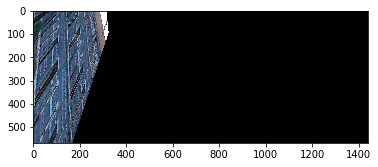

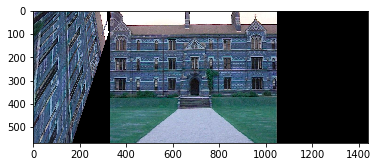

(568, 720, 3)


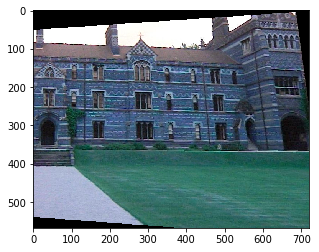

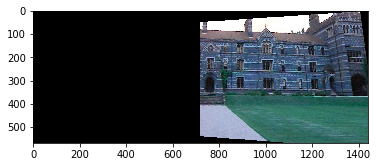

3 on 2


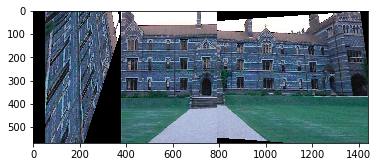

In [41]:
finalH[0,2]=0

finalH2[0,2]=0
newimg2 = cv2.warpPerspective (img1, finalH,(img1.shape[1]+img2.shape[1], img2.shape[0]), flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)

plt.imshow(newimg2)
plt.show()


newimg2[0:img2.shape[0],img1.shape[1]-390:-390] = img2

plt.imshow(newimg2)
plt.show()

newimg4 = cv2.warpPerspective(img3,finalH2,(img3.shape[1], newimg2.shape[0]), flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)
print(newimg4.shape[0:3])

plt.imshow(newimg4)
plt.show()

xint = np.zeros((newimg4.shape[0],newimg4.shape[1],newimg4.shape[2]))

img4reformed = np.hstack((xint,newimg4))

plt.imshow(np.uint8(img4reformed))
plt.show()

img4reformed[0:img4reformed.shape[0],50:790]=newimg2[:,:740]

print('3 on 2')
plt.imshow(np.uint8(img4reformed))
plt.show()



plt.imsave('panoramaimage.jpg',img4reformed)





28


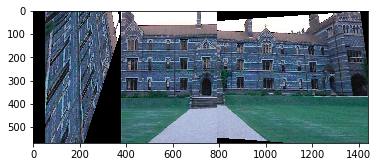

In [42]:
print(len(good))


img4reformed=np.uint8(img4reformed)
plt.imshow(img4reformed)
plt.show()
plt.imsave('panorama.jpg',img4reformed)


